In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import wrds
from IPython.display import display_html


%load_ext autoreload
%autoreload 2

# Do not run this

In [2]:
df = pd.read_csv("/Users/juansarmiento/Documents/Python/Momentum_strat/bqxrhjeno0vfjime.csv")
len(df.PERMNO.unique())

9292

In [3]:
permno = df.PERMNO.unique()
permno

array([10001, 10002, 10009, ..., 92930, 93105, 93316])

In [2]:
db = wrds.Connection(wrds_username='jus22')

Loading library list...
Done


In [ ]:
# the below code was to retrieve important information from CRSP. No need to run it, that's why it is in a comment
'''
ident = permno[0]
data = db.raw_sql(f"""select permno, date, prc, ret, shrout, cfacpr, cfacshr, ask, bid, askhi, openprc 
                        from crsp.dsf
                        where permno = {ident}
                        and date>='01/01/2000'""", 
                     date_cols=['date'])

for ident in permno[1:]:
    
    df2 = db.raw_sql(f"""select permno, date, prc, ret, shrout, cfacpr, cfacshr, ask, bid, askhi, openprc 
                        from crsp.dsf
                        where permno = {ident}
                        and date>='01/01/2000'""", 
                     date_cols=['date'])
    
    data = pd.concat([data, df2])
    print(ident)

data
'''

# Start here - Data Loading

The data below was retrieved from the previous section named **Do not run this**. In that section, there is a database that includes information about tickers from the NYSE, AMEX, NASDAQ, and ARCA that were around in the year 2000 (this is to avoid survivorship bias). I used those tickers to run an analysis from 2000-2006 to start to get a sense of the results and address the following questions:

1. Is there reversal or momentum behaviour?
2. Do company characteristics such as volatility and size impact in any way the behaviour of the portfolio? this should be helpful to see what type of strategy to use depending on the stock characteristics.
3. What formation and trading period is best to use?

Based on my findings on those questions, I will adjust the parameters for the backtesting during three periods (out of sample): 2006-2012, 2012-2018, and 2018-2022. Analysing during three different periods using the same parameter will help to see how robust the strategy is. Additionally, in each of the periods analysed, tickers are retrieved at the beginning of the period to avoid biases.

In [2]:
# the data below contains daily data on returns, price, shares outstanding, bid/ask, and as well other factors to calculate market share and adjusted price.
data1 = pd.read_csv(r'/Users/juansarmiento/Docs/momentum_strat/data.csv', index_col=0, parse_dates=True)

/var/folders/h8/bchvx6k164x6vc2vv8x27mgc0000gn/T/ipykernel_19075/821638209.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data1 = pd.read_csv(r'/Users/juansarmiento/Docs/momentum_strat/data.csv', index_col=0, parse_dates=True)


In [3]:
date_col = pd.to_datetime(data1['date'], format='mixed')
date_col

0    2000-01-03
1    2000-01-04
2    2000-01-05
3    2000-01-06
4    2000-01-07
        ...    
47   2000-03-10
48   2000-03-13
49   2000-03-14
50   2000-03-15
51   2000-03-16
Name: date, Length: 23703267, dtype: datetime64[ns]

In [4]:
data1["date"] = date_col
data1.set_index("date",inplace=True)
# cfacpr is the adjustment factor for share price. So to get the adjusted price I can do the following division prc/cfacpr
data1["adj_prc"] = data1["prc"]/data1["cfacpr"]
# cfacshr is the adjustment factor for shares. So to get the adjusted shares i can do the follwing product cfacshr*shrout
data1["market_cap"] = data1["adj_prc"] * data1["cfacshr"] * data1["shrout"]
# NOTE: The ret column in data1 is adjusted and it includes dividends so I will use this column for the returns

In [5]:
# converting the dataframe to a more friendly format columns -> PERMNO, index -> date
data_new = data1.reset_index().pivot(index='date', columns="permno")
data_new

prc                                                        
permno     10001.0 10002.0   10009.0 10012.0  10016.0  10019.0  10025.0   
date                                                                      
2000-01-03  8.5625   12.00  16.75000  8.0000  19.6250   9.8125  24.7500  \
2000-01-04  8.4375   12.50  14.50000  7.3125  18.0000  10.1250  24.7500   
2000-01-05  8.5625   12.00 -15.59375  8.0000  18.6250   9.6250 -24.1875   
2000-01-06  8.5000  -12.25  14.87500  7.5000  17.8125   9.6250  23.5000   
2000-01-07  8.4375   13.00 -15.25000  7.5625  18.0000   8.7500  25.2500   
...            ...     ...       ...     ...      ...      ...      ...   
2022-12-23     NaN     NaN       NaN     NaN      NaN      NaN      NaN   
2022-12-27     NaN     NaN       NaN     NaN      NaN      NaN      NaN   
2022-12-28     NaN     NaN       NaN     NaN      NaN      NaN      NaN   
2022-12-29     NaN     NaN       NaN     NaN      NaN      NaN      NaN   
2022-12-30     NaN     NaN       NaN     NaN      NaN      NaN      NaN   

                                            ...    market_cap                 
permno         10026.0 10028.0     10032.0  ...       92583.0       92655.0   
date                                        ...                               
2000-01-03   20.750000  6.0000   43.250000  ...   9957.875000  9.124224e+06  \
2000-01-04   19.000000  5.6250   42.093750  ...  10301.250000  9.007519e+06   
2000-01-05   20.125000  6.0000   42.062500  ...  10644.625000  8.986299e+06   
2000-01-06   20.187500  5.8750   42.125000  ...  10644.625000  9.315196e+06   
2000-01-07   20.250000  5.6875   42.437500  ... -10644.625000  1.040798e+07   
...                ...     ...         ...  ...           ...           ...   
2022-12-23  153.399994  5.2900  104.559998  ...  18677.552901  4.964290e+08   
2022-12-27  152.089996  5.2300  104.290001  ...  17775.720544  4.970643e+08   
2022-12-28  150.779999  5.2600  102.110001  ...  17734.949611  4.937567e+08   
2022-12-29  151.940002  5.1600  103.150002  ...  19039.590311  4.950929e+08   
2022-12-30  149.710007  5.2600  102.930000  ...  18346.908254  4.953731e+08   

                                                                         
permno       92663.0        92690.0       92807.0   92866.0    92874.0   
date                                                                     
2000-01-03  127338.0   60440.187500  89336.706515  104304.0  16961.750  \
2000-01-04  128455.0   59531.312500  90267.297208  104940.0  17959.500   
2000-01-05  127338.0   59531.312500  92128.478593  106530.0  16961.750   
2000-01-06  129572.0   60894.625000  91197.887900  105258.0  17460.625   
2000-01-07  127338.0   60440.187500  92593.773940  105576.0  16961.750   
...              ...            ...           ...       ...        ...   
2022-12-23       NaN  904021.661730  68288.850163       NaN        NaN   
2022-12-27       NaN  902907.042522  67604.250816       NaN        NaN   
2022-12-28       NaN  883957.080865  67433.100979       NaN        NaN   
2022-12-29       NaN  907365.838270  68117.700326       NaN        NaN   
2022-12-30       NaN  897333.521261  67433.100979       NaN        NaN   

                                             
permno         92930.0   93105.0    93316.0  
date                                         
2000-01-03  435869.875  433125.0  39873.375  
2000-01-04  422150.000  435750.0  36984.000  
2000-01-05  429537.625  435750.0  41414.375  
2000-01-06  424260.750  435750.0  40836.500  
2000-01-07  429537.625  433125.0  42184.875  
...                ...       ...        ...  
2022-12-23         NaN       NaN        NaN  
2022-12-27         NaN       NaN        NaN  
2022-12-28         NaN       NaN        NaN  
2022-12-29         NaN       NaN        NaN  
2022-12-30         NaN       NaN        NaN  

[5787 rows x 102124 columns]

In [6]:
# Extracting the returns, market cap, and price from the above dataframe
rets = data_new["ret"]
market_cap = data_new["market_cap"]
prc = data_new["prc"]

In [32]:
# Alternatively to doing all the above I can load the datasets and start from here (delete the comments):
'''
rets = pd.read_csv(r'/Users/juansarmiento/Docs/momentum_strat/rets.csv', index_col=0, parse_dates=True)
market_cap = pd.read_csv(r'/Users/juansarmiento/Docs/momentum_strat/market_cap.csv', index_col=0, parse_dates=True)
prc = pd.read_csv(r'/Users/juansarmiento/Docs/momentum_strat/prc.csv', index_col=0, parse_dates=True)
'''

# Strategy building

Before starting with the strategy building, I wanted to check the median deviation of the bid and ask with respect to the price so that I consider this spread in the backtesting:

In [7]:
(data1["bid"]/data1["prc"]-1).median()

-0.0008855546944588344

In [8]:
(data1["ask"]/data1["prc"]-1).median()

0.0005045845014479688

In [9]:
((data1["ask"] - data1["bid"])/data1["prc"]).median()

0.0025706915664731513

The spread goes from -.08% to .05%, which is really low and the median bid-ask spread with respect to the price is .2%, generally a bid-ask spread of less than 1% of the stock's price is typically considered to be relatively tight and indicative of good liquidity. This is considering all stocks in the database, however I am only trading the most liquid ones. Only stocks trading at a minimum of 10 USD in the last formation day and that have not recorded any NA's during the formation period will be considered so the average spread should be lower than that. However to remain conservative, I'll use a .08% of spread with respect to the bid and ask.

In [10]:
def ticket_generation(quintiles_small, quintiles_large, cum_rets, n_portfolios):
    '''
    This function was built for the mom_size_vol_strat function shown below.
    This function provides as output the identifiers for each of the stocks that are part of each of the 25 portfolios for small and large companies. Technically it is a ticker (PERMNO)
    generator function.
    '''
    id_per_quint_small = {}
    id_per_quint_large = {}

    # the variables quintiles_small and quintiles_large contains all the stocks and their corresponding quintile rank according to their volatility
    # in the below loop, I am separating each of the stocks according to their rank and storing them in two dictionaries (one for the largecap group and the other for the smallcap)
    for quintile in np.arange(1,6):
        id_per_quint_small[quintile] = quintiles_small[quintiles_small==quintile].index
        id_per_quint_large[quintile] = quintiles_large[quintiles_large==quintile].index

    tickers_volret_small = {}
    tickers_volret_large = {}

    # Until this point, I have 2 groups (small and large cap) and per group I have another 5 groups depending on volatility
    # In the below loop, I am going through each of those 5 groups and assigning a quintile rank to the stock based on the past cumulative return
    for quintile_vol in id_per_quint_small.keys():
        tickers_per_vol_small = id_per_quint_small[quintile_vol]
        tickers_per_vol_large = id_per_quint_large[quintile_vol]
        cum_rets_quintile_small = np.ceil(cum_rets[tickers_per_vol_small].rank(pct=True).mul(n_portfolios)) #here I am assigning the rank number to the group of small caps
        cum_rets_quintile_large = np.ceil(cum_rets[tickers_per_vol_large].rank(pct=True).mul(n_portfolios)) #here I am assigning the rank number to the group of large caps

        # In the below loop I am separating again in groups each of the stocks according to their quintile rank on past cumulative returns. 
        for quintile_ret in np.arange(1,6):
            tickers_volret_small[f'vol{quintile_vol}_ret{quintile_ret}'] = cum_rets_quintile_small[cum_rets_quintile_small==quintile_ret].index
            tickers_volret_large[f'vol{quintile_vol}_ret{quintile_ret}'] = cum_rets_quintile_large[cum_rets_quintile_large==quintile_ret].index
            
    # Now I have 2 groups depending on the size and each group is composed of 25 groups -> all possible combinations between the quintile on volatilities and returns.
    return tickers_volret_small, tickers_volret_large

def results_generation(results_df, trading_rets, tickers_volret, trading_cost, spread_cost):
    '''
    You give as input to this function the returns of the trading period, the tickers per portfolio, and trading/spread costs.
    The functions gives as output a dataframe containing the daily returns per portfolio in the trading period.
    '''
    for port in tickers_volret.keys(): #looping through each portfolio to extract the tickers 

        rets_df = (trading_rets[tickers_volret[port]]).copy()
        rets_df.iloc[0] = rets_df.iloc[0] - trading_cost - spread_cost #After the formation period is over, it is assumed that we open the position the next day in the morning so 
        # the above line of code is subtracting the trading and spread costs in the first day of trading.
        rets_df.iloc[-1] = rets_df.iloc[-1] - trading_cost - spread_cost #Subtracting trading and spread costs in the last day of trading because I am closing the positions
        n_stocks_port = len(rets_df.columns)
        wealth = (rets_df+1).cumprod().sum(axis=1) #Creating a wealth index that adds up all our positions in the portfolio
        port_rets = wealth.pct_change() # Calculating the returns in our wealth index
        port_rets[0] = wealth[0]/n_stocks_port-1 # From .pct_change() the first day will show an NA, but this is wrong. Here I am adding the correct return in the first day of trading 
        results_df.loc[port_rets.index, port] = port_rets
        
    return results_df
    

def mom_size_vol_strat(rets=rets, market_cap=market_cap, prc=prc, formation_period=90, trading_period=5, price_filter=10, spread_costv=.0008, trading_costv=.0003):
    '''
    This function backtests a momentum/reversal strategy creating portfolios based on the size and volatility of a stock. Parameters of the function:
    
    * rets: dataframe with the daily returns of the stocks
    * market_cap: dataframe that incudes the market capitalisation of the stocks.
    * prc: dataframe that included the non adjusted price of a stock. I am only considering stocks that have a price over 10, so this dataframe will be used to do this filering.
    * formation_period: It is set by default to 90 days but can be adjusted. The unit is days.
    * trading_period: It is set by default to 5 days, but can be adjusted. The unit is days.
    * Price_filter: As mentioned before, I am filtering out stocks that are below 10 in the last day of the formation period. This parameter can be adjusted.
    * spread_costv: To make trading realistic, I included a parameter to include the potential spread of a transaction. This helps to consider that I may enter a trade not at the exact
    closing price. It is set to .08% by default based on historical data on the NYSE, AMEX, ARCA, and NASDAQ. I am being conservative with this metric as the stocks I am trading 
    are the most liquid, hence should have lower spread than the average.
    * trading_costv: I included trading costs, it is set to to .03% by default considering that in a broker such as IB, it is charged 0.0035USD per share in the american market for 
    a volume traded of ≤ 300,000 shares per month. In this case, I am only trading shares > 10USD, so if a share is 10USD the transaction cost would be 0.035%, if a share is 50USD
    the transaction cost would be .007%. .03% seems to be a conservative fee.
    
    The function gives as output 4 dataframes:
    *results_large: a Dataframe that includes the daily returns of 25 portfolios (all possible combinations between the quintiles based on size and returns) that have the larger market
    cap stocks.
    *results_small: a Dataframe that includes the daily returns of 25 portfolios (all possible combinations between the quintiles based on size and returns) that have the smaller market
    cap stocks.
    *results_small_ls: a Dataframe that includes the daily returns of 5 portfolios (from the least volatile to the most volatile) that have the smaller market cap stocks. These portfolios
    are long/short and are taking advantage of the reversal effect, they go long on the losers and go short on the winners.
    *results_large_ls: a Dataframe that includes the daily returns of 5 portfolios (from the least volatile to the most volatile) that have the larger market cap stocks. These portfolios
    are long/short and are taking advantage of the reversal effect, they go long on the losers and go short on the winners.
    '''

    n_portfoliosv=5 #number of classifications based on past cumulative returns
    start_period = 0
    results_small = pd.DataFrame(index=rets.iloc[start_period+formation_period:].index) #dataframe where the results for the small cap portfolios will be stored
    results_large = pd.DataFrame(index=rets.iloc[start_period+formation_period:].index) #dataframe where the results for the large cap portfolios will be stored
    n_vol_div = 5 #number of classifications based on past volatility
    
    name_long_portv = [] #Storing the name of the long portfolios within the long/short portfolio. The names are stored using the for loop below
    name_short_portv = [] #Storing the name of the short portfolios within the long/short portfolio. The names are stored using the for loop below
    
    for vol_port in np.arange(1, n_vol_div+1):
        port_long = f'vol{vol_port}_ret1'
        port_short = f'vol{vol_port}_ret5'
        name_long_portv.append(port_long)
        name_short_portv.append(port_short)
    
    while start_period+formation_period < rets.shape[0]:

        # filtering on price > 10
        price_bool = prc.iloc[start_period+formation_period-1] > price_filter
        # we drop any ticker that has at least one NA in the formation period
        formation_rets = rets.iloc[start_period:start_period+formation_period].loc[:, price_bool].dropna(axis=1)
        # Based on the filtering done on price and NA's, I filter the trading_rets dataframe
        trading_retsv = rets.iloc[start_period+formation_period:min(start_period+formation_period+trading_period, rets.shape[0])][formation_rets.columns]
        cum_retsv = (formation_rets+1).prod()-1

        std = formation_rets.std()

        #Segmenting the stocks in two groups based on size/market capitalisation
        n_stocks = len(formation_rets.columns)
        n_stocks_small = round(n_stocks/2)
        n_stocks_big = n_stocks - n_stocks_small
        id_small_stock = (market_cap[formation_rets.columns].iloc[start_period:start_period+formation_period].mean().sort_values()).iloc[:n_stocks_small].index
        id_large_stock = (market_cap[formation_rets.columns].iloc[start_period:start_period+formation_period].mean().sort_values()).iloc[n_stocks_small:].index

        #Adding the quintile rank based on past volatility to both big and small stocks
        quintiles_smallv = np.ceil(std[id_small_stock].rank(pct=True).mul(n_vol_div))
        quintiles_largev = np.ceil(std[id_large_stock].rank(pct=True).mul(n_vol_div))

        # Generating the tickers in each of the 25 portfolios for each group (big and small stocks)
        tickers_volret_small, tickers_volret_large = ticket_generation(quintiles_small=quintiles_smallv, quintiles_large=quintiles_largev, cum_rets=cum_retsv, n_portfolios=n_portfoliosv)
   
        # Generating the daily returns for each of the 25 portfolios for each group (big and small stocks)
        results_small = results_generation(results_df=results_small, trading_rets=trading_retsv, tickers_volret=tickers_volret_small, trading_cost=trading_costv, spread_cost=spread_costv)
        results_large = results_generation(results_df=results_large, trading_rets=trading_retsv, tickers_volret=tickers_volret_large, trading_cost=trading_costv, spread_cost=spread_costv)

        start_period += trading_period
    
    # Generating the daily return for each of the 5 portfolios (from the least volatile to the most volatile). These portfolios are long/short - shorting winners and going long on losers
        #First for small caps 
    results_small_long = results_small[name_long_portv]
    results_small_short = results_small[name_short_portv]
    name_col = results_small_long.columns + '_minus_' + results_small_short.columns
    results_small_long.columns = name_col
    results_small_short.columns = name_col
    results_small_ls = results_small_long - results_small_short
    
        #First for the larger firms
    results_large_long = results_large[name_long_portv]
    results_large_short = results_large[name_short_portv]
    results_large_long.columns = name_col
    results_large_short.columns = name_col
    results_large_ls = results_large_long - results_large_short
    
    
    return results_large, results_small, results_small_ls, results_large_ls

## version 2
def ticket_generation(quintiles_small, quintiles_large, cum_rets, n_portfolios):
    '''
    
    '''
    id_per_quint_small = {}
    id_per_quint_large = {}

    for quintile in np.arange(1,6):
        id_per_quint_small[quintile] = quintiles_small[quintiles_small==quintile].index
        id_per_quint_large[quintile] = quintiles_large[quintiles_large==quintile].index

    tickers_volret_small = {}
    tickers_volret_large = {}

    for quintile_vol in id_per_quint_small.keys():
        tickers_per_vol_small = id_per_quint_small[quintile_vol]
        tickers_per_vol_large = id_per_quint_large[quintile_vol]
        cum_rets_quintile_small = np.ceil(cum_rets[tickers_per_vol_small].rank(pct=True).mul(n_portfolios))
        cum_rets_quintile_large = np.ceil(cum_rets[tickers_per_vol_large].rank(pct=True).mul(n_portfolios))

        for quintile_ret in np.arange(1,6):
            tickers_volret_small[f'vol{quintile_vol}_ret{quintile_ret}'] = cum_rets_quintile_small[cum_rets_quintile_small==quintile_ret].index
            tickers_volret_large[f'vol{quintile_vol}_ret{quintile_ret}'] = cum_rets_quintile_large[cum_rets_quintile_large==quintile_ret].index
            
    return tickers_volret_small, tickers_volret_large

def results_generation(results_df, trading_rets, tickers_volret, trading_cost, spread_cost, long_port, short_port, results_df_long, results_df_short):
    '''
    
    '''
    for port in tickers_volret.keys():

        rets_df = (trading_rets[tickers_volret[port]]).copy()
        
        if port in long_port:
            rets_df_l = rets_df.copy()
            rets_df_l.iloc[0] = rets_df_l.iloc[0] - trading_cost - spread_cost
            rets_df_l.iloc[-1] = rets_df_l.iloc[-1] - trading_cost - spread_cost
            n_stocks_port_l = len(rets_df_l.columns)
            wealth_l = (rets_df_l+1).cumprod().sum(axis=1)
            port_rets_l = wealth_l.pct_change()
            port_rets_l[0] = wealth_l[0]/n_stocks_port_l-1
            results_df_long.loc[port_rets_l.index, port] = port_rets_l
            
        if port in short_port:
            rets_df_s = rets_df.copy()
            rets_df_s.iloc[0] = rets_df_s.iloc[0] + trading_cost + spread_cost
            rets_df_s.iloc[-1] = rets_df_s.iloc[-1] + trading_cost + spread_cost
            n_stocks_port_s = len(rets_df_s.columns)
            wealth_s = (rets_df_s+1).cumprod().sum(axis=1)
            port_rets_s = wealth_s.pct_change()
            port_rets_s[0] = wealth_s[0]/n_stocks_port_s-1
            results_df_short.loc[port_rets_s.index, port] = port_rets_s
            
        rets_df.iloc[0] = rets_df.iloc[0] - trading_cost - spread_cost
        rets_df.iloc[-1] = rets_df.iloc[-1] - trading_cost - spread_cost
        n_stocks_port = len(rets_df.columns)
        wealth = (rets_df+1).cumprod().sum(axis=1)
        port_rets = wealth.pct_change()
        port_rets[0] = wealth[0]/n_stocks_port-1
        results_df.loc[port_rets.index, port] = port_rets
        
    return results_df, results_df_long, results_df_short
    

def mom_size_vol_strat(rets=rets, market_cap=market_cap, prc=prc, formation_period=90, trading_period=5, price_filter=10, n_portfoliosv=5, spread_costv=.0008, trading_costv=.0003):
    '''
    
    '''

    #function starts here
    start_period = 0
    results_small = pd.DataFrame(index=rets.iloc[start_period+formation_period:].index)
    results_large = pd.DataFrame(index=rets.iloc[start_period+formation_period:].index)
    results_small_long = pd.DataFrame(index=rets.iloc[start_period+formation_period:].index)
    results_small_short = pd.DataFrame(index=rets.iloc[start_period+formation_period:].index)
    results_large_long = pd.DataFrame(index=rets.iloc[start_period+formation_period:].index)
    results_large_short = pd.DataFrame(index=rets.iloc[start_period+formation_period:].index)
    n_vol_div = 5
    name_long_portv = []
    name_short_portv = []
    
    for vol_port in np.arange(1, n_vol_div+1):
        port_long = f'vol{vol_port}_ret1'
        port_short = f'vol{vol_port}_ret5'
        name_long_portv.append(port_long)
        name_short_portv.append(port_short)
    
    #name_col = name_long_portv + '_minus_' + name_short_portv
    
    while start_period+formation_period < rets.shape[0]:

        # filtering on price > 10
        price_bool = prc.iloc[start_period+formation_period-1] > price_filter
        # we drop any ticker that has at least one NA in the formation period
        formation_rets = rets.iloc[start_period:start_period+formation_period].loc[:, price_bool].dropna(axis=1)
        trading_retsv = rets.iloc[start_period+formation_period:min(start_period+formation_period+trading_period, rets.shape[0])][formation_rets.columns]
        cum_retsv = (formation_rets+1).prod()-1

        std = formation_rets.std()

        n_stocks = len(formation_rets.columns)
        n_stocks_small = round(n_stocks/2)
        n_stocks_big = n_stocks - n_stocks_small
        id_small_stock = (market_cap[formation_rets.columns].iloc[start_period:start_period+formation_period].mean().sort_values()).iloc[:n_stocks_small].index
        id_large_stock = (market_cap[formation_rets.columns].iloc[start_period:start_period+formation_period].mean().sort_values()).iloc[n_stocks_small:].index

        quintiles_smallv = np.ceil(std[id_small_stock].rank(pct=True).mul(n_vol_div))
        quintiles_largev = np.ceil(std[id_large_stock].rank(pct=True).mul(n_vol_div))


        #Maybe all the below can go in a function named ticket generation:
        ########################################################################################################################
        tickers_volret_small, tickers_volret_large = ticket_generation(quintiles_small=quintiles_smallv, quintiles_large=quintiles_largev, cum_rets=cum_retsv, n_portfolios=n_portfoliosv)
        ########################################################################################################################
        #Maybe all the below can go in a function named results generation:
        ########################################################################################################################
        results_small, results_small_long, results_small_short = results_generation(results_df=results_small, trading_rets=trading_retsv, tickers_volret=tickers_volret_small, 
                                                                                    trading_cost=trading_costv, spread_cost=spread_costv, long_port = name_long_portv, 
                                                                                    short_port = name_short_portv, results_df_long=results_small_long, results_df_short=results_small_short)
        results_large, results_large_long, results_large_short = results_generation(results_df=results_large, trading_rets=trading_retsv, tickers_volret=tickers_volret_large, 
                                                                                    trading_cost=trading_costv, spread_cost=spread_costv, long_port = name_long_portv, 
                                                                                    short_port = name_short_portv, results_df_long=results_large_long, results_df_short=results_large_short)
        ########################################################################################################################
        start_period += trading_period
    
    name_col_small = results_small_long.columns + '_minus_' + results_small_short.columns
    results_small_long.columns = name_col_small
    results_small_short.columns = name_col_small
    results_small_ls = results_small_long - results_small_short
    
    name_col_large = results_large_long.columns + '_minus_' + results_large_short.columns
    results_large_long.columns = name_col_large
    results_large_short.columns = name_col_large
    results_large_ls = results_large_long - results_large_short
    
    
    
    return results_large, results_small, results_small_ls, results_large_ls

Now, I am going to run the backtest function from 2000 to 2006 under different parameters for the length of the formation and trading period. From the results, I will be able to answer the questions that I set at the beginning, which are shown below again: 

1. Is there reversal or momentum behaviour?
2. Do company characteristics such as volatility and size impact in any way the behaviour of the portfolio? this should be helpful to see what type of strategy to use depending on the stock characteristics.
3. What formation and trading period is best to use?

In [11]:
rets_largecap_2005, rets_smallcap_2005, rets_smallcap_ls_2005, rets_largecap_ls_2005 = mom_size_vol_strat(rets.loc[:"2006"], formation_period=20, trading_period=5)
rets_largecap_2010, rets_smallcap_2010, rets_smallcap_ls_2010, rets_largecap_ls_2010 = mom_size_vol_strat(rets.loc[:"2006"], formation_period=20, trading_period=10)

rets_largecap_3010, rets_smallcap_3010, rets_smallcap_ls_3010, rets_largecap_ls_3010 = mom_size_vol_strat(rets.loc[:"2006"], formation_period=30, trading_period=10)
rets_largecap_3005, rets_smallcap_3005, rets_smallcap_ls_3005, rets_largecap_ls_3005 = mom_size_vol_strat(rets.loc[:"2006"], formation_period=30, trading_period=5)

rets_largecap_6005, rets_smallcap_6005, rets_smallcap_ls_6005, rets_largecap_ls_6005 = mom_size_vol_strat(rets.loc[:"2006"], formation_period=60, trading_period=5)
rets_largecap_6010, rets_smallcap_6010, rets_smallcap_ls_6010, rets_largecap_ls_6010 = mom_size_vol_strat(rets.loc[:"2006"], formation_period=60, trading_period=10)

rets_largecap_9005, rets_smallcap_9005, rets_smallcap_ls_9005, rets_largecap_ls_9005 = mom_size_vol_strat(rets.loc[:"2006"], formation_period=90, trading_period=5)
rets_largecap_9010, rets_smallcap_9010, rets_smallcap_ls_9010, rets_largecap_ls_9010 = mom_size_vol_strat(rets.loc[:"2006"], formation_period=90, trading_period=10)

rets_largecap_25205, rets_smallcap_25205, rets_smallcap_ls_25205, rets_largecap_ls_25205 = mom_size_vol_strat(rets.loc[:"2006"], formation_period=252, trading_period=5)
rets_largecap_25210, rets_smallcap_25210, rets_smallcap_ls_25210, rets_largecap_ls_25210 = mom_size_vol_strat(rets.loc[:"2006"], formation_period=252, trading_period=10)

In [13]:
rets_largecap_2005

,vol1_ret1,vol1_ret2,vol1_ret3,vol1_ret4,vol1_ret5,vol2_ret1,vol2_ret2,vol2_ret3,vol2_ret4,vol2_ret5,...,vol4_ret1,vol4_ret2,vol4_ret3,vol4_ret4,vol4_ret5,vol5_ret1,vol5_ret2,vol5_ret3,vol5_ret4,vol5_ret5
date,,,,,,,,,,,,,,,,,,,,,
2000-02-01,0.004078,0.002849,0.000804,0.000641,-0.001736,0.008289,0.002968,0.004260,0.008937,0.001867,...,0.020763,0.009283,0.018051,0.022069,0.027300,0.025386,0.012373,0.018836,0.019042,0.024846
2000-02-02,0.001800,-0.001877,0.002624,-0.000649,0.000281,0.003096,-0.004415,0.002181,-0.003007,-0.009778,...,0.026361,0.011309,0.020928,0.018941,0.018944,0.023700,0.015022,0.028490,0.016765,0.015686
2000-02-03,0.010686,0.006479,0.007020,0.009437,0.008219,0.007750,0.002777,0.007943,0.004062,0.005690,...,0.024745,0.021820,0.024551,0.034497,0.032463,0.035210,0.022223,0.040343,0.039918,0.039772
2000-02-04,-0.002454,-0.003048,-0.005213,-0.004258,-0.018074,-0.001275,-0.001798,-0.004646,-0.002438,-0.002117,...,-0.001301,0.009748,0.015151,0.015401,0.016966,0.003553,0.000568,0.015703,0.028108,0.025149
2000-02-07,-0.009904,-0.005177,-0.007681,-0.003273,-0.003321,-0.008663,-0.011413,-0.009555,-0.006010,-0.002223,...,0.003874,0.016294,0.015536,0.021781,0.019803,0.003592,0.021210,0.034802,0.015943,0.041269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-12-22,-0.002496,-0.003581,-0.003286,-0.003344,-0.003716,-0.003724,-0.005730,-0.005001,-0.004259,-0.004220,...,-0.004238,-0.004021,-0.005002,-0.005459,-0.005038,-0.004977,-0.007916,-0.000465,-0.005616,-0.006172
2006-12-26,0.004672,0.003629,0.003671,0.005035,0.003792,0.005951,0.007369,0.005246,0.006989,0.003957,...,0.004736,0.003946,0.005015,0.003807,0.005970,0.000099,0.003050,0.001894,0.002968,0.002410
2006-12-27,0.006755,0.004933,0.004877,0.006435,0.006503,0.006961,0.011446,0.009613,0.007881,0.006554,...,0.010035,0.012181,0.011055,0.012063,0.008525,0.009896,0.015253,0.012887,0.013906,0.010296


# Displaying results

In [226]:
def display_table_mean(data_largecap, data_smallcap, data_largecap_ls, data_smallcap_ls, formation_period, trading_period):
    '''
    This function was created to portray the results from the backtest function in a nicer format.
    '''
    columns = ["vol1", "vol2", "vol3", "vol4", "vol5"]
    index = ["ret1", "ret2", "ret3", "ret4", "ret5", "ret1-ret5"]
    df_large = pd.DataFrame(index = index, columns = columns)
    df_small = df_large.copy()
    
    data_largecap_mean = data_largecap.mean()
    data_smallcap_mean = data_smallcap.mean()
    
    for index in data_largecap_mean.index:
        mean = data_largecap_mean[index]
        index_split = index.split('_')
        df_large.loc[index_split[1], index_split[0]] = mean
        
    df_large.loc["ret1-ret5"] = data_largecap_ls.mean().values
    
    for index in data_smallcap_mean.index:
        mean = data_smallcap_mean[index]
        index_split = index.split('_')
        df_small.loc[index_split[1], index_split[0]] = mean
    
    df_small.loc["ret1-ret5"] = data_smallcap_ls.mean().values

    styles = [dict(selector="caption", props=[("background-color", "cyan"), ("font-weight", "bold")])]
    df_large_styler = df_large.style.set_table_attributes("style='display:inline'").set_caption(f'Large firms, F={formation_period}, T={trading_period}').set_table_styles(styles)
    df_small_styler = df_small.style.set_table_attributes("style='display:inline'").set_caption(f'Small firms, F={formation_period}, T={trading_period}').set_table_styles(styles)
    
    
    return display_html(df_small_styler._repr_html_()+df_large_styler._repr_html_(), raw=True)

In total, I have **25 portfolios per firm size** plus 5 extra portfolios, which are the long/short portfolios. Each of the 25 portfolios is formed from all possible combinations between the volatility and return quintiles. In the tables below I will show the **average daily return** for each of the 25 portfolios and the long/short portfolios. 

In the columns and indexes of the tables, the number 1 refers to the 1st quintile and the number 5 to the 5th quintile, meaning that vol5 is the most volatile portfolio, ret1 the former losers, and ret5 the winners. 

The long/short portfolio is technically a reversal strategy. It is going long on the losers and going short on the winners. This is because, for such a short timeframe (max 2 weeks), there seems to be more reversal behavior for both small and big stocks.

Initially, I will show the results for the period 2000-2006 for different formation and trading periods. **F** stands for the number of days that lasted the formation period and **T** stands for the number of trading days. Based on these results, I will choose a specific formation and trading period to use in subsequent periods.

## Results 2000-2006

In [234]:
display_table_mean(rets_largecap_2005, rets_smallcap_2005, rets_largecap_ls_2005, rets_smallcap_ls_2005, 20, 5)

,vol1,vol2,vol3,vol4,vol5
ret1,-0.000376,0.000334,0.000584,0.000512,0.000369
ret2,-0.001202,0.000190,0.000363,0.000384,-0.000126
ret3,-0.001046,0.000133,0.000167,0.000093,-0.000322
ret4,-0.000916,0.000117,0.000150,-0.000110,-0.000425
ret5,-0.000566,-0.000128,-0.000111,-0.000279,-0.000757
ret1-ret5,0.000191,0.000462,0.000695,0.000791,0.001125
,vol1,vol2,vol3,vol4,vol5
ret1,0.000059,0.000173,0.000232,-0.000022,-0.000215
ret2,-0.000664,0.000138,-0.000102,-0.000132,-0.000799
ret3,-0.000820,0.000115,0.000004,-0.000092,-0.000830


In the portfolios above, we can see that the average daily returns are higher for the portfolio conformed of former losers so we experience reversal in both small and large firms. Surprisingly, it seems that middle quintiles for volatility are the ones that have the best performance considering the long-only portfolios. 

In [235]:
display_table_mean(rets_largecap_2010, rets_smallcap_2010, rets_largecap_ls_2010, rets_smallcap_ls_2010, 20, 10)

,vol1,vol2,vol3,vol4,vol5
ret1,-0.000164,0.000528,0.000617,0.000455,0.000294
ret2,-0.000921,0.000270,0.000563,0.000484,-0.000034
ret3,-0.000979,0.000396,0.000426,0.000286,-0.000359
ret4,-0.000595,0.000299,0.000351,0.000170,-0.000114
ret5,-0.000372,0.000134,0.000163,0.000053,-0.000251
ret1-ret5,0.000208,0.000394,0.000454,0.000402,0.000545
,vol1,vol2,vol3,vol4,vol5
ret1,0.000226,0.000393,0.000316,-0.000007,-0.000236
ret2,-0.000494,0.000318,0.000243,0.000094,-0.000722
ret3,-0.000480,0.000390,0.000142,0.000083,-0.000553


In the portfolios above, we can see that the average daily returns are higher for the portfolio conformed of former losers so we experience reversal in both small and large firms. Surprisingly, it seems that middle quintiles for volatility are the ones that have the best performance considering the long-only portfolios.

In [236]:
display_table_mean(rets_largecap_3005, rets_smallcap_3005, rets_largecap_ls_3005, rets_smallcap_ls_3005, 30, 5)

,vol1,vol2,vol3,vol4,vol5
ret1,-0.000371,0.000439,0.000680,0.000352,0.000131
ret2,-0.000999,0.000273,0.000462,0.000310,-0.000359
ret3,-0.000805,0.000238,0.000098,0.000133,-0.000395
ret4,-0.000926,-0.000005,0.000039,-0.000047,-0.000561
ret5,-0.000657,-0.000127,-0.000186,-0.000384,-0.000854
ret1-ret5,0.000286,0.000566,0.000867,0.000736,0.000985
,vol1,vol2,vol3,vol4,vol5
ret1,0.000052,0.000323,0.000236,-0.000016,-0.000363
ret2,-0.000530,0.000140,0.000099,-0.000217,-0.000672
ret3,-0.000576,0.000014,0.000091,-0.000288,-0.001025


The same can be concluded from the portfolios above: In the portfolios above, we can see that the average daily returns are higher for the portfolio conformed of former losers so we experience reversal in both small and large firms. Surprisingly, it seems that middle quintiles for volatility are the ones that have the best performance considering the long-only portfolios.

In [237]:
display_table_mean(rets_largecap_3010, rets_smallcap_3010, rets_largecap_ls_3010, rets_smallcap_ls_3010, 30, 10)

,vol1,vol2,vol3,vol4,vol5
ret1,-0.000207,0.000468,0.000764,0.000478,0.000167
ret2,-0.000725,0.000460,0.000556,0.000417,-0.000232
ret3,-0.000630,0.000400,0.000340,0.000165,-0.000303
ret4,-0.000698,0.000313,0.000329,0.000261,-0.000403
ret5,-0.000463,0.000219,0.000048,-0.000030,-0.000543
ret1-ret5,0.000256,0.000249,0.000716,0.000508,0.000710
,vol1,vol2,vol3,vol4,vol5
ret1,0.000260,0.000482,0.000406,0.000222,-0.000199
ret2,-0.000314,0.000331,0.000276,-0.000080,-0.000520
ret3,-0.000461,0.000287,0.000189,-0.000122,-0.000785


Same pattern as mentioned in previous tables.

In [238]:
display_table_mean(rets_largecap_6005, rets_smallcap_6005, rets_largecap_ls_6005, rets_smallcap_ls_6005, 60, 5)

,vol1,vol2,vol3,vol4,vol5
ret1,-0.000323,0.000453,0.000387,0.000222,-0.000320
ret2,-0.000504,0.000340,0.000490,0.000177,-0.000696
ret3,-0.000564,0.000119,0.000173,0.000131,-0.000546
ret4,-0.000734,0.000089,0.000176,-0.000136,-0.000709
ret5,-0.000478,-0.000133,-0.000228,-0.000232,-0.001031
ret1-ret5,0.000155,0.000586,0.000614,0.000454,0.000711
,vol1,vol2,vol3,vol4,vol5
ret1,0.000012,0.000362,0.000249,-0.000137,-0.000464
ret2,-0.000384,0.000144,0.000081,-0.000162,-0.000816
ret3,-0.000487,0.000060,0.000046,-0.000236,-0.000898


Same pattern as mentioned in previous tables.

In [239]:
display_table_mean(rets_largecap_6010, rets_smallcap_6010, rets_largecap_ls_6010, rets_smallcap_ls_6010, 60, 10)

,vol1,vol2,vol3,vol4,vol5
ret1,-0.000218,0.000564,0.000470,0.000250,-0.000217
ret2,-0.000350,0.000535,0.000612,0.000349,-0.000522
ret3,-0.000348,0.000362,0.000429,0.000292,-0.000398
ret4,-0.000404,0.000277,0.000291,0.000145,-0.000538
ret5,-0.000241,0.000194,0.000053,0.000099,-0.000907
ret1-ret5,0.000023,0.000369,0.000417,0.000151,0.000690
,vol1,vol2,vol3,vol4,vol5
ret1,0.000266,0.000530,0.000396,0.000068,-0.000270
ret2,-0.000208,0.000310,0.000247,0.000039,-0.000719
ret3,-0.000264,0.000355,0.000277,-0.000062,-0.000710


Same pattern as mentioned in previous tables.

In [240]:
display_table_mean(rets_largecap_9005, rets_smallcap_9005, rets_largecap_ls_9005, rets_smallcap_ls_9005, 90, 5)

,vol1,vol2,vol3,vol4,vol5
ret1,-0.000145,0.000439,0.000514,0.000333,-0.000269
ret2,-0.000256,0.000327,0.000440,0.000308,-0.000574
ret3,-0.000426,0.000186,0.000245,0.000197,-0.000498
ret4,-0.000459,0.000134,0.000203,-0.000003,-0.000658
ret5,-0.000360,-0.000135,-0.000244,-0.000206,-0.000934
ret1-ret5,0.000215,0.000575,0.000757,0.000538,0.000664
,vol1,vol2,vol3,vol4,vol5
ret1,0.000142,0.000293,0.000203,0.000024,-0.000402
ret2,-0.000259,0.000236,0.000069,-0.000070,-0.000610
ret3,-0.000193,0.000052,0.000011,0.000005,-0.000649


In [241]:
display_table_mean(rets_largecap_9010, rets_smallcap_9010, rets_largecap_ls_9010, rets_smallcap_ls_9010, 90, 10)

,vol1,vol2,vol3,vol4,vol5
ret1,0.000077,0.000632,0.000586,0.000406,-0.000129
ret2,-0.000058,0.000450,0.000588,0.000459,-0.000412
ret3,-0.000179,0.000476,0.000494,0.000380,-0.000344
ret4,-0.000317,0.000256,0.000432,0.000135,-0.000346
ret5,-0.000140,0.000107,0.000049,0.000031,-0.000708
ret1-ret5,0.000218,0.000525,0.000537,0.000375,0.000579
,vol1,vol2,vol3,vol4,vol5
ret1,0.000368,0.000440,0.000357,0.000257,-0.000198
ret2,0.000001,0.000455,0.000253,0.000145,-0.000476
ret3,0.000013,0.000312,0.000328,0.000038,-0.000415


In [242]:
display_table_mean(rets_largecap_25205, rets_smallcap_25205, rets_largecap_ls_25205, rets_smallcap_ls_25205, 252, 5)

,vol1,vol2,vol3,vol4,vol5
ret1,-0.000065,0.000221,0.000362,0.000322,-0.000289
ret2,-0.000105,0.000359,0.000354,0.000113,-0.000240
ret3,-0.000177,0.000217,0.000334,0.000151,-0.000472
ret4,-0.000058,0.000118,0.000187,-0.000087,-0.000280
ret5,-0.000018,-0.000113,-0.000216,-0.000121,-0.000111
ret1-ret5,-0.000047,0.000334,0.000578,0.000443,-0.000177
,vol1,vol2,vol3,vol4,vol5
ret1,0.000016,0.000096,0.000004,-0.000060,-0.000509
ret2,0.000087,0.000125,0.000027,-0.000110,-0.000441
ret3,-0.000007,0.000033,0.000009,-0.000027,-0.000613


In [243]:
display_table_mean(rets_largecap_25210, rets_smallcap_25210, rets_largecap_ls_25210, rets_smallcap_ls_25210, 252, 10)

,vol1,vol2,vol3,vol4,vol5
ret1,0.000121,0.000302,0.000476,0.000401,-0.000188
ret2,0.000041,0.000476,0.000540,0.000323,-0.000128
ret3,0.000051,0.000473,0.000456,0.000346,-0.000195
ret4,0.000147,0.000339,0.000352,0.000205,-0.000138
ret5,0.000233,0.000133,0.000089,0.000142,0.000048
ret1-ret5,-0.000112,0.000169,0.000387,0.000259,-0.000236
,vol1,vol2,vol3,vol4,vol5
ret1,0.000235,0.000298,0.000169,0.000134,-0.000259
ret2,0.000286,0.000297,0.000252,0.000106,-0.000399
ret3,0.000223,0.000273,0.000259,0.000126,-0.000413


**Conclusion** 

I was not able to find any different behaviours (momentum/reversal) depending on company characteristics, in this case, volatility and size. For all companies in this sample, it seems that a reversal is more likely. The below patterns were found:

* Strong evidence of reversal behaviour.
* The group of small firms tends to have better performance than the group of large firms.
* The quintiles in the middle in terms of volatility are the ones exhibiting the best performance for long-only portfolios. For the long/short portfolios, the most volatile portfolios (5th quintile) are the ones exhibiting the best performance. Considering both, long only and long/short portfolios, the long/short portfolio with the most volatile stocks  is the one exhibiting the best performance across most periods.

**Next steps**

Based on a thorough analysis from 2000 to 2006, was concluded that **the best formation and trading periods are 60-10 and 30-10** and we are particularly interested in the performance of the **reversal strategy (ret1-ret5) for the most volatile portfolios (5th quintile on volatility)**. Below I am going to analyse, how the reversal strategy performs for both formation and trading periods from 2006-2012, 2012-2018, and from 2018-2022. I am particularly interested in the performance of the most volatile portfolio, but I will run the backtest on all 5 quintiles.

On each period analysed, I get the tickers available at the beginning of the period to avoid survivorship bias. For instance, when analysing the period from 2006 to 2012, I will retrieve from CRSP the tickers available in the NYSE, AMEX, NASDAQ, and ARCA exchanges in the year 2006.

# OOS Backtesting

**Note:** The below results are for long/short portfolio. As mentioned before, based on the analysis from 2000-2006 was realised that there is a reversal effect so I am going to long the former losers (1st quintile on rets or ret1) and I am shorting former winners (5th quintile on rets or ret5). The best portfolio to have is the one with the small cap stocks and most volatile (5th quintile on volatility or vol5). In summary, I want to see the performance of:

* Reversal strategy - long/short portfolio (long on losers, short on winners)
* Small cap stocks.
* Most volatile group (5th quintile)

Even though, I am interested only in that portfolio, I will as well run the backtest on large firms and for the other 4 groups based on volatility. In the graphs and charts below, portfolios are named in the following convention -> vol1_ret1_minus_vol1_ret5, the number next to ret or vol implies the quintile rank. For instance, in that example I am going long on the portfolio with least volatile and loser stocks (both vol and ret have a quintile rank of 1). On the other hand, I am going short the least volatile and winner stocks (vol is the 1st quintile and ret has the 5th quintile)

In [13]:
def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

def skewness(r):
    """
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3

def kurtosis(r):
    """
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4

def annualize_rets(r, periods_per_year):
    """
    Annualises a set of returns
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def annualize_vol(r, periods_per_year):
    """
    Annualises the vol of a set of returns
    """
    return r.std()*(periods_per_year**0.5)

def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

from scipy.stats import norm
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))

def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def summary_stats(r, periods_per_year,riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=periods_per_year)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=periods_per_year)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=periods_per_year)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
       "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

## 2006-2012

### Data Loading

In [ ]:
# the below code was to retrieve important information from CRSP. No need to run it, that's why it is in a comment

'''
df_2006 = pd.read_csv(r'/Users/juansarmiento/Docs/momentum_strat/wcqzjkjnhg16yt5n_2006.csv')
len(df_2006.PERMNO.unique())

permno_2006 = df_2006.PERMNO.unique()
permno_2006

ident = permno_2006[0]
data_2006 = db.raw_sql(f"""select permno, date, prc, ret, shrout, cfacpr, cfacshr, ask, bid, openprc 
                        from crsp.dsf
                        where permno = {ident}
                        and date>='01/01/2006' and date<='12/31/2012'""", date_cols=['date'])

data_2006 

for ident in permno_2006[1:]:
    
    df2 = db.raw_sql(f"""select permno, date, prc, ret, shrout, cfacpr, cfacshr, ask, bid, openprc 
                        from crsp.dsf
                        where permno = {ident}
                        and date>='01/01/2006' and date<='12/31/2012'""", date_cols=['date'])
    
    data_2006 = pd.concat([data_2006, df2])
    print(ident)

'''

In [14]:
# The data below comes from the code in comments in the previous cell
data_2006 = pd.read_csv(r'/Users/juansarmiento/Docs/momentum_strat/data_2006.csv', index_col=0, parse_dates=True)

/var/folders/h8/bchvx6k164x6vc2vv8x27mgc0000gn/T/ipykernel_14105/892674370.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_2006 = pd.read_csv(r'/Users/juansarmiento/Docs/momentum_strat/data_2006.csv', index_col=0, parse_dates=True)


In [15]:
data_2006.dtypes

permno     float64
date        object
prc        float64
ret        float64
shrout     float64
cfacpr     float64
cfacshr    float64
ask        float64
bid        float64
openprc    float64
dtype: object

In [16]:
# if the type of the date column is object run the following:
date_col_2006 = pd.to_datetime(data_2006['date'], format='mixed')
date_col_2006

0      2006-01-03
1      2006-01-04
2      2006-01-05
3      2006-01-06
4      2006-01-09
          ...    
1084   2010-04-26
1085   2010-04-27
1086   2010-04-28
1087   2010-04-29
1088   2010-04-30
Name: date, Length: 10192327, dtype: datetime64[ns]

In [17]:
data_2006["date"] = date_col_2006
data_2006.set_index("date",inplace=True)
# cfacpr is the adjustment factor for share price. So to get the adjusted price I can do the following division prc/cfacpr
data_2006["adj_prc"] = data_2006["prc"]/data_2006["cfacpr"]
# cfacshr is the adjustment factor for shares. So to get the adjusted shares i can do the follwing product cfacshr*shrout
data_2006["market_cap"] = data_2006["adj_prc"] * data_2006["cfacshr"] * data_2006["shrout"]
data_2006
# NOTE: The ret column is adjusted and it includes dividends so I will use this column for the returns

,permno,prc,ret,shrout,cfacpr,cfacshr,ask,bid,openprc,adj_prc,market_cap
date,,,,,,,,,,,
2006-01-03,10001.0,9.690,-0.001031,2930.0,1.5,1.5,9.83,9.69,9.70,6.460000,28391.698771
2006-01-04,10001.0,9.800,0.011352,2930.0,1.5,1.5,9.92,9.80,9.77,6.533333,28714.000559
2006-01-05,10001.0,9.550,-0.025510,2930.0,1.5,1.5,9.50,9.37,9.70,6.366667,27981.500559
2006-01-06,10001.0,9.399,-0.015812,2930.0,1.5,1.5,9.41,9.29,9.50,6.266000,27539.070492
2006-01-09,10001.0,8.920,-0.050963,2930.0,1.5,1.5,9.58,8.90,9.16,5.946667,26135.600224
...,...,...,...,...,...,...,...,...,...,...,...
2010-04-26,93105.0,7.140,-0.140794,3298.0,1.0,1.0,7.20,7.18,8.51,7.140000,23547.719560
2010-04-27,93105.0,6.360,-0.109244,3298.0,1.0,1.0,6.33,6.28,7.00,6.360000,20975.280440
2010-04-28,93105.0,5.890,-0.073899,3298.0,1.0,1.0,5.96,5.95,6.47,5.890000,19425.219560


In [18]:
data_new_2006 = data_2006.reset_index().pivot(index='date', columns="permno")
data_new_2006

prc                                                       
permno     10001.0    10002.0    10025.0    10026.0 10028.0    10032.0   
date                                                                     
2006-01-03  9.6900  20.219999  25.510000  60.930000    2.06  24.360001  \
2006-01-04  9.8000  20.010000  25.370001  61.470001    2.15  23.799999   
2006-01-05  9.5500  20.070000  26.450001  63.570000   -2.18  23.940001   
2006-01-06  9.3990  20.209999  27.110001  31.400000    2.00  24.830000   
2006-01-09  8.9200  20.120001  27.389999  30.860001    2.01  22.500000   
...            ...        ...        ...        ...     ...        ...   
2012-12-24  9.2412   2.800000  56.880001  63.110001    5.24  25.459999   
2012-12-26  9.2400   2.760000  56.799999  62.380001    5.10  25.360001   
2012-12-27  9.1900   2.700000  56.939999  62.070000    5.08  25.420000   
2012-12-28  9.2120   2.720000  57.450001  61.680000    5.14  25.290001   
2012-12-31  9.3300   2.780000  59.230000  63.883099    5.43  25.799999   

                                                     ...    market_cap   
permno     10042.0    10044.0    10051.0    10056.0  ...       92340.0   
date                                                 ...                 
2006-01-03    0.79  15.790000   5.830000  30.400000  ...  23196.420382  \
2006-01-04    0.78  16.700001   5.670000  30.299999  ...  22434.196022   
2006-01-05    0.75  17.299999   5.890000  30.629999  ...  22627.500000   
2006-01-06    0.74  17.010000   6.020000  30.040001  ...  23273.999383   
2006-01-09    0.78  16.940001   5.970000  30.030001  ...  23273.999383   
...            ...        ...        ...        ...  ...           ...   
2012-12-24     NaN  10.760000  27.469999        NaN  ...           NaN   
2012-12-26     NaN  10.700000  27.030001        NaN  ...           NaN   
2012-12-27     NaN  10.550000  27.139999        NaN  ...           NaN   
2012-12-28     NaN  10.540000  27.320000        NaN  ...           NaN   
2012-12-31     NaN  10.560000  27.360001        NaN  ...           NaN   

                                                                      
permno           92399.0       92583.0       92655.0        92663.0   
date                                                                  
2006-01-03  28177.819338  18361.750579  8.426145e+07  993366.750000  \
2006-01-04  27772.801104  19029.449942  8.446620e+07  981553.742731   
2006-01-05  27020.620441  18877.699363  8.420685e+07  978332.007269   
2006-01-06  26557.740883  17967.200232  8.585850e+07  970814.670042   
2006-01-09  27454.569338  17603.000579  8.381100e+07  969740.735462   
...                  ...           ...           ...            ...   
2012-12-24           NaN  -5664.010143  5.602889e+07            NaN   
2012-12-26           NaN   5481.299921  5.538535e+07            NaN   
2012-12-27           NaN   5182.319810  5.561008e+07            NaN   
2012-12-28           NaN   5149.099842  5.501761e+07            NaN   
2012-12-31           NaN   5049.439937  5.540578e+07            NaN   

                                                                         
permno            92690.0        92807.0        92874.0        92930.0   
date                                                                     
2006-01-03  152761.682219   97071.677048  113006.836872  623613.354172  \
2006-01-04  153149.401849   97292.802109  108669.740370  623995.298630   
2006-01-05  152470.885563   95302.718735  108252.437796  615592.180573   
2006-01-06  151695.446302   99061.760422  104977.896326  626414.409714   
2006-01-09  150823.084067  102157.437469  101895.979265  617502.000000   
...                   ...            ...            ...            ...   
2012-12-24  172015.500000   57861.277204   29488.253740            NaN   
2012-12-26  171679.852318   56417.151285   29348.320866            NaN   
2012-12-27  169666.014238   56994.800735   29867.210807            NaN   
2012-12-28  170840.765121   55454.402204   29877.800361   

In [19]:
rets_2006 = data_new_2006["ret"]
market_cap_2006 = data_new_2006["market_cap"]
prc_2006 = data_new_2006["prc"]

### Backtesting 2006-2012 

For this dataset from 2006 to 2012, as well the average bid-ask spread remains below .08% 

In [20]:
((data_2006["ask"] - data_2006["bid"])/data_2006["prc"]).median()

0.0019119984719329366

In [21]:
(data_2006["bid"]/data_2006["prc"]-1).median()

-0.000851862378031476

In [22]:
(data_2006["ask"]/data_2006["prc"]-1).median()

0.00042681300689650925

In [23]:
rets2006_largecap_3010, rets2006_smallcap_3010, rets2006_smallcap_ls_3010, rets2006_largecap_ls_3010 = mom_size_vol_strat(rets=rets_2006, market_cap=market_cap_2006, prc=prc_2006,
                                                                                                                          formation_period=30, trading_period=10)
rets2006_largecap_6010, rets2006_smallcap_6010, rets2006_smallcap_ls_6010, rets2006_largecap_ls_6010 = mom_size_vol_strat(rets=rets_2006, market_cap=market_cap_2006, prc=prc_2006, 
                                                                                                                          formation_period=60, trading_period=10)

### Formation 30 - trading 10

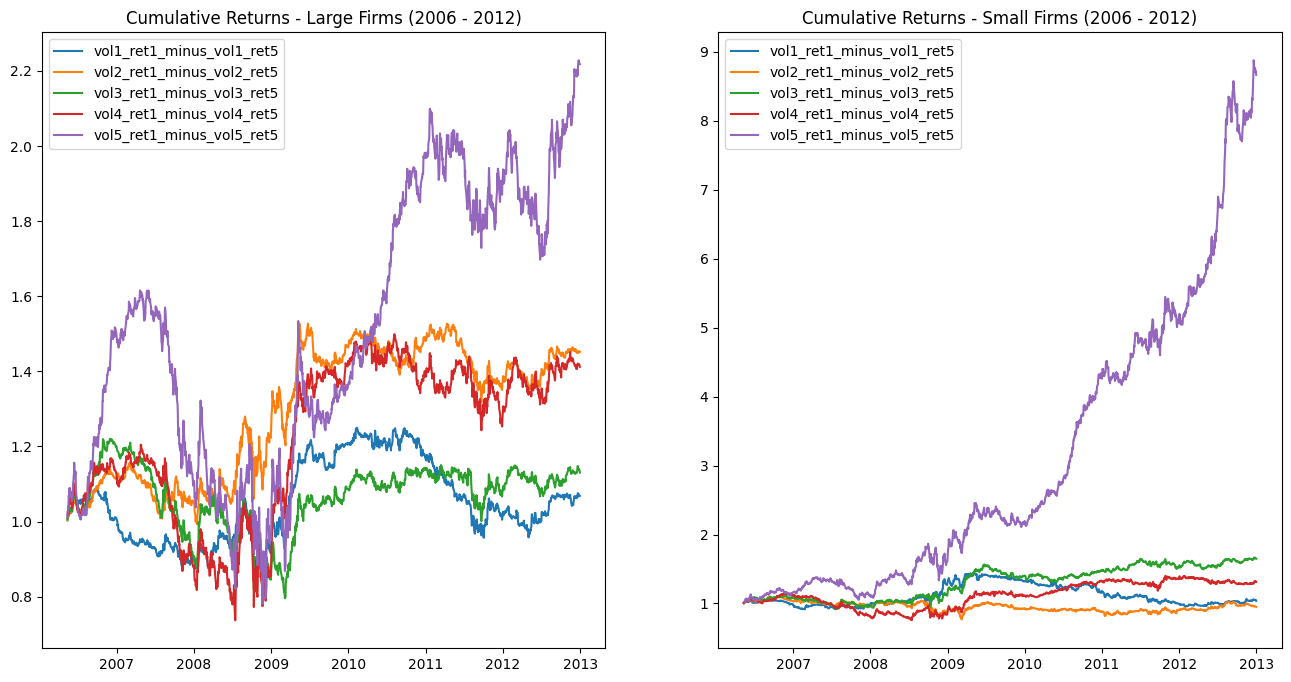

In [24]:
labels = rets2006_largecap_ls_3010.columns
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot((rets2006_largecap_ls_3010+1).cumprod(), label=labels)
ax[0].legend(loc='upper left')
ax[0].set_title("Cumulative Returns - Large Firms (2006 - 2012)")
ax[1].plot((rets2006_smallcap_ls_3010+1).cumprod(), label=labels)
ax[1].legend(loc='upper left')
ax[1].set_title("Cumulative Returns - Small Firms (2006 - 2012)")
#sns.scatterplot(x='feature_20', y = 'feature_15', data=df, hue='Class', ax=ax[1])
plt.show()

#### Summary Statistics Large Firms (2006-2012)

In [25]:
summary_stats(rets2006_largecap_ls_3010, 252, .03) #For the sharpe ratio, I am assuming a risk free rate of 3%

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
vol1_ret1_minus_vol1_ret5,0.009997,0.115733,0.975479,11.085194,0.008582,0.015759,-0.167832,-0.234431
vol2_ret1_minus_vol2_ret5,0.057854,0.118472,1.305875,18.970037,0.006608,0.014697,0.228280,-0.170499
vol3_ret1_minus_vol3_ret5,0.018663,0.144842,1.025893,15.687963,0.009713,0.018861,-0.076011,-0.348006
vol4_ret1_minus_vol4_ret5,0.053412,0.189082,1.333153,17.437727,0.010930,0.024399,0.120218,-0.388168
vol5_ret1_minus_vol5_ret5,0.127662,0.268437,0.881691,10.938131,0.019996,0.036360,0.353248,-0.517103


#### Summary Statistics Small Firms (2006-2012)

In [26]:
summary_stats(rets2006_smallcap_ls_3010, 252, .03) #For the sharpe ratio, I am assuming a risk free rate of 3%

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
vol1_ret1_minus_vol1_ret5,0.005239,0.141342,1.257458,21.278828,0.007851,0.020681,-0.170109,-0.338366
vol2_ret1_minus_vol2_ret5,-0.007781,0.146254,1.076794,19.394918,0.009071,0.020481,-0.250839,-0.302963
vol3_ret1_minus_vol3_ret5,0.078326,0.142516,1.185151,22.843796,0.007569,0.018230,0.329245,-0.177620
vol4_ret1_minus_vol4_ret5,0.042036,0.154246,0.371068,11.042866,0.013141,0.020475,0.075756,-0.342353
vol5_ret1_minus_vol5_ret5,0.384969,0.206457,0.386655,6.530572,0.017617,0.026099,1.669469,-0.284095


### Formation 60 - trading 10

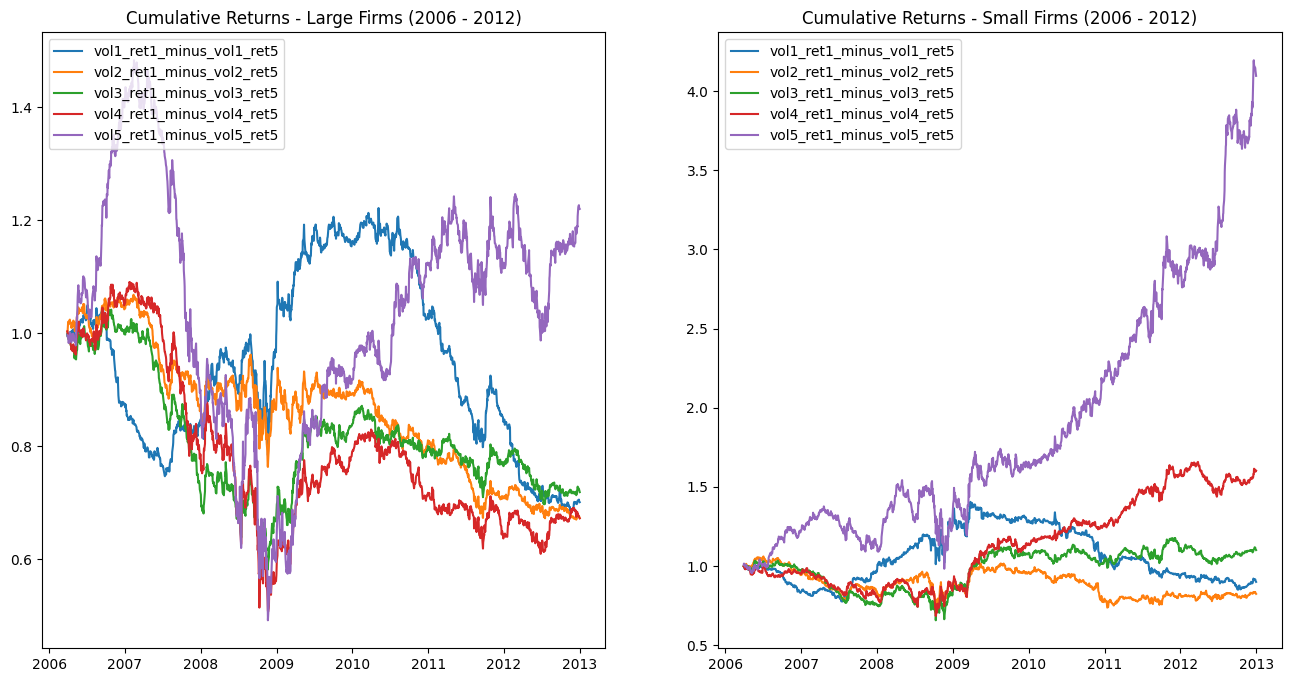

In [27]:
labels = rets2006_largecap_ls_6010.columns
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot((rets2006_largecap_ls_6010+1).cumprod(), label=labels)
ax[0].legend(loc='upper left')
ax[0].set_title("Cumulative Returns - Large Firms (2006 - 2012)")
ax[1].plot((rets2006_smallcap_ls_6010+1).cumprod(), label=labels)
ax[1].legend(loc='upper left')
ax[1].set_title("Cumulative Returns - Small Firms (2006 - 2012)")
#sns.scatterplot(x='feature_20', y = 'feature_15', data=df, hue='Class', ax=ax[1])
plt.show()

#### Summary Statistics Large Firms (2006-2012)

In [28]:
summary_stats(rets2006_largecap_ls_6010, 252, .03) #For the sharpe ratio, I am assuming a risk free rate of 3%

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
vol1_ret1_minus_vol1_ret5,-0.051260,0.119168,0.675756,11.081252,0.009795,0.017343,-0.662115,-0.440159
vol2_ret1_minus_vol2_ret5,-0.057006,0.107087,0.865946,16.290300,0.007739,0.014867,-0.788908,-0.372596
vol3_ret1_minus_vol3_ret5,-0.047744,0.132176,0.594378,17.030901,0.010033,0.017693,-0.571123,-0.453077
vol4_ret1_minus_vol4_ret5,-0.057085,0.175761,1.061548,26.706179,0.009509,0.024235,-0.481107,-0.534862
vol5_ret1_minus_vol5_ret5,0.029879,0.252047,0.655467,16.487719,0.018460,0.034686,-0.000481,-0.668137


#### Summary Statistics Small Firms (2006-2012)

In [29]:
summary_stats(rets2006_smallcap_ls_6010, 252, .03) #For the sharpe ratio, I am assuming a risk free rate of 3%

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
vol1_ret1_minus_vol1_ret5,-0.015520,0.147409,1.055668,19.579599,0.009203,0.021748,-0.299852,-0.395011
vol2_ret1_minus_vol2_ret5,-0.028267,0.147926,0.803588,19.321260,0.010084,0.021367,-0.382472,-0.339777
vol3_ret1_minus_vol3_ret5,0.014326,0.151653,0.892344,18.965979,0.009965,0.019867,-0.100365,-0.364499
vol4_ret1_minus_vol4_ret5,0.072334,0.155935,0.485249,13.341090,0.012380,0.020364,0.263599,-0.320905
vol5_ret1_minus_vol5_ret5,0.232348,0.215033,0.383740,9.571940,0.018043,0.028134,0.913703,-0.363079


## 2012-2018

### Data Loading

In [ ]:
# the below code was to retrieve important information from CRSP. No need to run it, that's why it is in a comment
'''
df_2012 = pd.read_csv(r'/Users/juansarmiento/Docs/momentum_strat/nffvvfle0tj0kull_2012.csv')
len(df_2012.PERMNO.unique())

permno_2012 = df_2012.PERMNO.unique()
permno_2012

ident = permno_2012[0]
data_2012 = db.raw_sql(f"""select permno, date, prc, ret, shrout, cfacpr, cfacshr, ask, bid, openprc 
                        from crsp.dsf
                        where permno = {ident}
                        and date>='01/01/2012' and date<='12/31/2018'""", date_cols=['date'])

data_2012 

for ident in permno_2012[1:]:
    
    df2 = db.raw_sql(f"""select permno, date, prc, ret, shrout, cfacpr, cfacshr, ask, bid, openprc 
                        from crsp.dsf
                        where permno = {ident}
                        and date>='01/01/2012' and date<='12/31/2018'""", date_cols=['date'])
    
    data_2012 = pd.concat([data_2012, df2])
    print(ident)
'''


In [30]:
# The below data was retrieved from CRSP using the sql query from the above cell
data_2012 = pd.read_csv(r'/Users/juansarmiento/Docs/momentum_strat/data_2012.csv', index_col=0, parse_dates=True)

/var/folders/h8/bchvx6k164x6vc2vv8x27mgc0000gn/T/ipykernel_14105/488703256.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_2012 = pd.read_csv(r'/Users/juansarmiento/Docs/momentum_strat/data_2012.csv', index_col=0, parse_dates=True)


In [31]:
data_2012.dtypes 

permno     float64
date        object
prc        float64
ret        float64
shrout     float64
cfacpr     float64
cfacshr    float64
ask        float64
bid        float64
openprc    float64
dtype: object

In [32]:
# if the type of the date column is object run the following:
date_col_2012 = pd.to_datetime(data_2012['date'])
date_col_2012

0      2012-01-03
1      2012-01-04
2      2012-01-05
3      2012-01-06
4      2012-01-09
          ...    
1755   2018-12-24
1756   2018-12-26
1757   2018-12-27
1758   2018-12-28
1759   2018-12-31
Name: date, Length: 10283940, dtype: datetime64[ns]

In [33]:
data_2012["date"] = date_col_2012
data_2012.set_index("date",inplace=True)
# cfacpr is the adjustment factor for share price. So to get the adjusted price I can do the following division prc/cfacpr
data_2012["adj_prc"] = data_2012["prc"]/data_2012["cfacpr"]
# cfacshr is the adjustment factor for shares. So to get the adjusted shares i can do the follwing product cfacshr*shrout
data_2012["market_cap"] = data_2012["adj_prc"] * data_2012["cfacshr"] * data_2012["shrout"]
data_2012
# NOTE: The ret column is adjusted and it includes dividends so I will use this column for the returns

,permno,prc,ret,shrout,cfacpr,cfacshr,ask,bid,openprc,adj_prc,market_cap
date,,,,,,,,,,,
2012-01-03,10001.0,11.440000,0.001751,8154.0,1.0,1.0,11.470000,11.350000,11.440000,11.440000,9.328176e+04
2012-01-04,10001.0,11.320000,-0.010490,8154.0,1.0,1.0,11.360000,11.330000,11.380000,11.320000,9.230328e+04
2012-01-05,10001.0,11.359900,0.003525,8154.0,1.0,1.0,11.360000,11.320000,11.350000,11.359900,9.262863e+04
2012-01-06,10001.0,11.330000,-0.002632,8154.0,1.0,1.0,11.350000,11.280000,11.370000,11.330000,9.238482e+04
2012-01-09,10001.0,11.320000,-0.000883,8154.0,1.0,1.0,11.350000,11.260000,11.280000,11.320000,9.230328e+04
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,93436.0,295.390015,-0.076242,171733.0,15.0,15.0,295.670013,295.459991,313.500000,19.692668,5.072821e+07
2018-12-26,93436.0,326.089996,0.103930,171733.0,15.0,15.0,326.079987,325.899994,300.000000,21.739333,5.600041e+07
2018-12-27,93436.0,316.130005,-0.030544,171733.0,15.0,15.0,316.130005,315.920013,319.839996,21.075334,5.428995e+07


In [34]:
data_new_2012 = data_2012.reset_index().pivot(index='date', columns="permno")

In [35]:
rets_2012 = data_new_2012["ret"]
market_cap_2012 = data_new_2012["market_cap"]
prc_2012 = data_new_2012["prc"]

### Backtesting 2012-2018

From 2012 to 2018, the average spread between the bid/ask and the adjusted price is way lower than before. However, I will keep the spread cost at .08% to be conservative.

In [36]:
((data_2012["ask"] - data_2012["bid"])/data_2012["prc"]).median()

0.0010925232208937616

In [37]:
(data_2012["bid"]/data_2012["prc"]-1).median()

-0.0003818338555904299

In [38]:
(data_2012["ask"]/data_2012["prc"]-1).median()

0.00023062339121060482

In [39]:
rets2012_largecap_3010, rets2012_smallcap_3010, rets2012_smallcap_ls_3010, rets2012_largecap_ls_3010 = mom_size_vol_strat(rets=rets_2012, market_cap=market_cap_2012, prc=prc_2012,
                                                                                                                          formation_period=30, trading_period=10)
rets2012_largecap_6010, rets2012_smallcap_6010, rets2012_smallcap_ls_6010, rets2012_largecap_ls_6010 = mom_size_vol_strat(rets=rets_2012, market_cap=market_cap_2012, prc=prc_2012, 
                                                                                                                          formation_period=60, trading_period=10)

### Formation 30 - trading 10

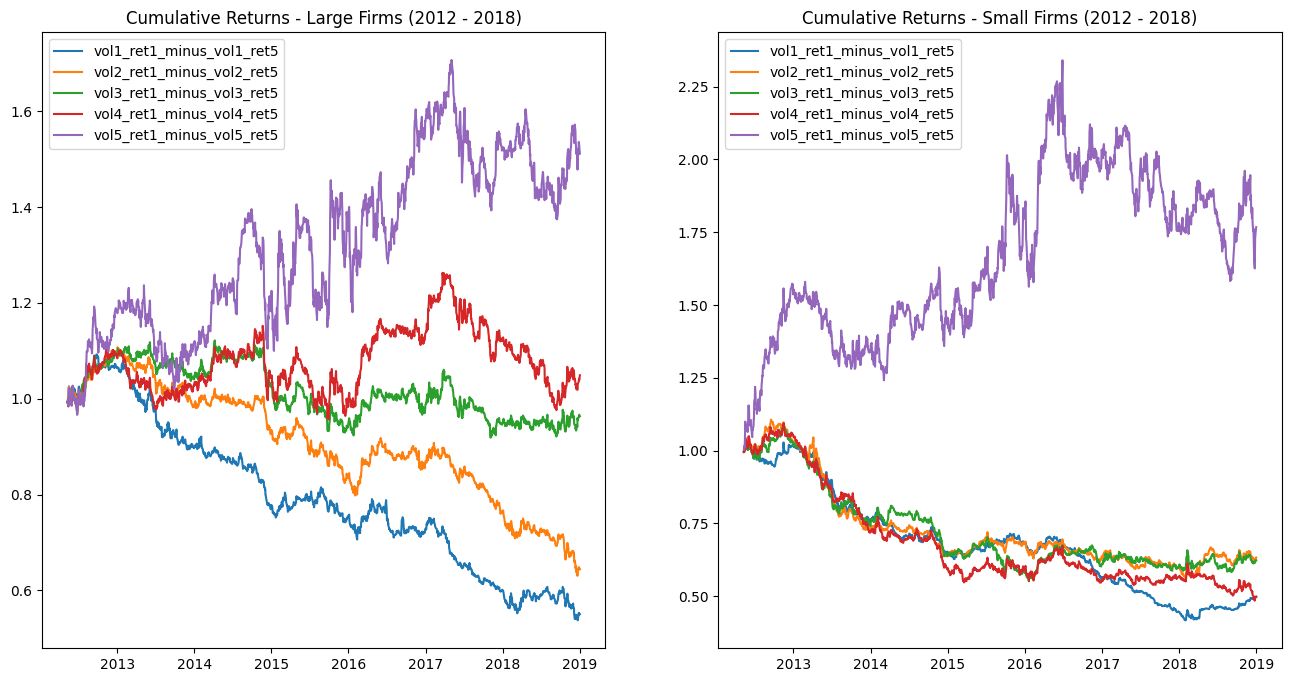

In [40]:
labels = rets2012_largecap_ls_3010.columns
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot((rets2012_largecap_ls_3010+1).cumprod(), label=labels)
ax[0].legend(loc='upper left')
ax[0].set_title("Cumulative Returns - Large Firms (2012 - 2018)")
ax[1].plot((rets2012_smallcap_ls_3010+1).cumprod(), label=labels)
ax[1].legend(loc='upper left')
ax[1].set_title("Cumulative Returns - Small Firms (2012 - 2018)")
plt.show()

#### Summary Statistics Large Firms (2012-2018)

In [41]:
summary_stats(rets2012_largecap_ls_3010, 252, .03) #For the sharpe ratio, I am assuming a risk free rate of 3%

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
vol1_ret1_minus_vol1_ret5,-0.086141,0.088572,0.237270,6.230980,0.008771,0.012567,-1.273212,-0.507790
vol2_ret1_minus_vol2_ret5,-0.064198,0.082301,0.198442,5.427208,0.008225,0.011644,-1.111345,-0.430737
vol3_ret1_minus_vol3_ret5,-0.005613,0.087516,0.347499,5.583848,0.008228,0.011896,-0.395123,-0.180639
vol4_ret1_minus_vol4_ret5,0.007238,0.107588,0.453344,5.272790,0.009883,0.013547,-0.205438,-0.226854
vol5_ret1_minus_vol5_ret5,0.064287,0.188762,0.375270,5.500090,0.017336,0.025238,0.176360,-0.211949


#### Summary Statistics Small Firms (2012-2018)

In [42]:
summary_stats(rets2012_smallcap_ls_3010, 252, .03) #For the sharpe ratio, I am assuming a risk free rate of 3%

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
vol1_ret1_minus_vol1_ret5,-0.099730,0.087831,1.432581,16.542357,0.005522,0.012388,-1.434174,-0.594270
vol2_ret1_minus_vol2_ret5,-0.066790,0.104732,1.054295,14.854620,0.007409,0.013441,-0.897353,-0.491009
vol3_ret1_minus_vol3_ret5,-0.068903,0.116632,0.421595,6.415814,0.010927,0.015838,-0.823396,-0.492768
vol4_ret1_minus_vol4_ret5,-0.100171,0.128703,0.500647,5.059227,0.012189,0.016992,-0.982067,-0.557257
vol5_ret1_minus_vol5_ret5,0.089741,0.214945,0.328779,4.341103,0.020174,0.027638,0.269858,-0.324054


### Formation 60 - trading 10

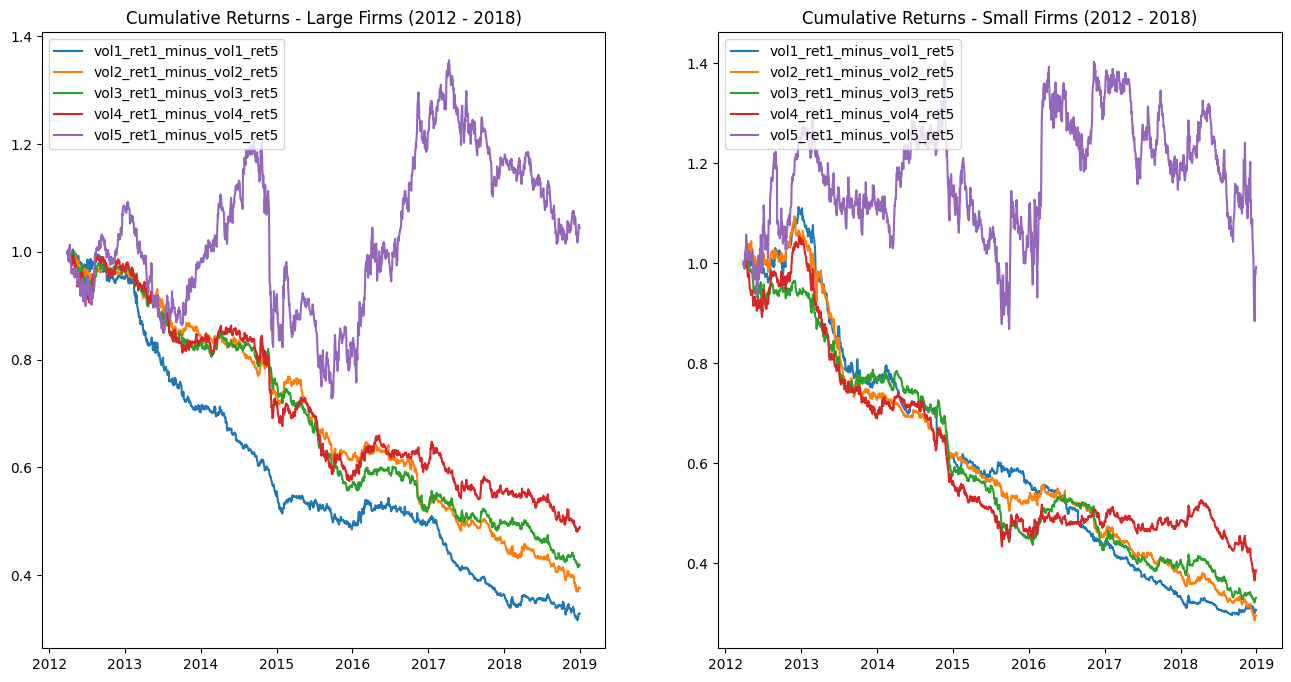

In [43]:
labels = rets2012_largecap_ls_6010.columns
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot((rets2012_largecap_ls_6010+1).cumprod(), label=labels)
ax[0].legend(loc='upper left')
ax[0].set_title("Cumulative Returns - Large Firms (2012 - 2018)")
ax[1].plot((rets2012_smallcap_ls_6010+1).cumprod(), label=labels)
ax[1].legend(loc='upper left')
ax[1].set_title("Cumulative Returns - Small Firms (2012 - 2018)")
plt.show()

#### Summary Statistics Large Firms (2012-2018)

In [44]:
summary_stats(rets2012_largecap_ls_6010, 252, .03) #For the sharpe ratio, I am assuming a risk free rate of 3%

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
vol1_ret1_minus_vol1_ret5,-0.151950,0.089042,0.297835,5.975180,0.009041,0.013153,-1.984111,-0.686477
vol2_ret1_minus_vol2_ret5,-0.134667,0.085641,-0.192821,7.551155,0.009227,0.012704,-1.866950,-0.634667
vol3_ret1_minus_vol3_ret5,-0.121047,0.087469,0.159237,4.673272,0.009119,0.012461,-1.676742,-0.585947
vol4_ret1_minus_vol4_ret5,-0.100451,0.104339,0.133010,6.188194,0.010533,0.014343,-1.213985,-0.518083
vol5_ret1_minus_vol5_ret5,0.006486,0.181879,0.091423,8.147192,0.017260,0.024554,-0.125545,-0.397732


#### Summary Statistics Small Firms (2012-2018)

In [45]:
summary_stats(rets2012_smallcap_ls_6010, 252, .03) #For the sharpe ratio, I am assuming a risk free rate of 3%

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
vol1_ret1_minus_vol1_ret5,-0.160787,0.094231,-0.504027,18.964086,0.009349,0.014285,-1.965904,-0.733337
vol2_ret1_minus_vol2_ret5,-0.165238,0.099921,0.285453,8.070539,0.009883,0.014995,-1.897216,-0.738456
vol3_ret1_minus_vol3_ret5,-0.151115,0.114459,0.094834,7.496940,0.011631,0.016467,-1.536441,-0.687271
vol4_ret1_minus_vol4_ret5,-0.131555,0.128204,0.276606,5.574938,0.012741,0.017660,-1.223579,-0.652817
vol5_ret1_minus_vol5_ret5,-0.001062,0.239294,0.428309,8.456029,0.021133,0.032637,-0.126052,-0.382287


## 2018 - 2022

### Data Loading

In [ ]:
# the below code was to retrieve important information from CRSP. No need to run it, that's why it is in a comment
'''
df_2018 = pd.read_csv(r'/Users/juansarmiento/Docs/momentum_strat/njpvc5u8siu43grr_2018.csv')
len(df_2018.PERMNO.unique())

permno_2018 = df_2018.PERMNO.unique()
permno_2018

ident = permno_2018[0]
data_2018 = db.raw_sql(f"""select permno, date, prc, ret, shrout, cfacpr, cfacshr, ask, bid, openprc 
                        from crsp.dsf
                        where permno = {ident}
                        and date>='01/01/2018'""", date_cols=['date'])

data_2018

for ident in permno_2018[1:]:
    
    df2 = db.raw_sql(f"""select permno, date, prc, ret, shrout, cfacpr, cfacshr, ask, bid, openprc 
                        from crsp.dsf
                        where permno = {ident}
                        and date>='01/01/2018'""", date_cols=['date'])
    
    data_2018 = pd.concat([data_2018, df2])
    print(ident)
'''

In [46]:
# The below data was retrieved from CRSP using the sql query from the cell above
data_2018 = pd.read_csv(r'/Users/juansarmiento/Docs/momentum_strat/data_2018.csv', index_col=0, parse_dates=True)

/var/folders/h8/bchvx6k164x6vc2vv8x27mgc0000gn/T/ipykernel_14105/1693766280.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_2018 = pd.read_csv(r'/Users/juansarmiento/Docs/momentum_strat/data_2018.csv', index_col=0, parse_dates=True)


In [47]:
data_2018.dtypes

permno     float64
date        object
prc        float64
ret        float64
shrout     float64
cfacpr     float64
cfacshr    float64
ask        float64
bid        float64
openprc    float64
dtype: object

In [48]:
# if the type of the date column is object run the following:
date_col_2018 = pd.to_datetime(data_2018['date'], format='mixed')
date_col_2018

0      2018-01-02
1      2018-01-03
2      2018-01-04
3      2018-01-05
4      2018-01-08
          ...    
1254   2022-12-23
1255   2022-12-27
1256   2022-12-28
1257   2022-12-29
1258   2022-12-30
Name: date, Length: 8627034, dtype: datetime64[ns]

In [49]:
data_2018["date"] = date_col_2018
data_2018.set_index("date",inplace=True)
# cfacpr is the adjustment factor for share price. So to get the adjusted price I can do the following division prc/cfacpr
data_2018["adj_prc"] = data_2018["prc"]/data_2018["cfacpr"]
# cfacshr is the adjustment factor for shares. So to get the adjusted shares i can do the follwing product cfacshr*shrout
data_2018["market_cap"] = data_2018["adj_prc"] * data_2018["cfacshr"] * data_2018["shrout"]
data_2018
# NOTE: The ret column is adjusted and it includes dividends so I will use this column for the returns

,permno,prc,ret,shrout,cfacpr,cfacshr,ask,bid,openprc,adj_prc,market_cap
date,,,,,,,,,,,
2018-01-02,10026.0,149.179993,-0.017454,18668.0,1.0,1.0,149.419998,149.179993,152.389999,149.179993,2.784892e+06
2018-01-03,10026.0,147.690002,-0.009988,18668.0,1.0,1.0,147.690002,147.410004,149.070007,147.690002,2.757077e+06
2018-01-04,10026.0,149.729996,0.013813,18668.0,1.0,1.0,149.720001,149.449997,147.770004,149.729996,2.795160e+06
2018-01-05,10026.0,148.300003,-0.009550,18668.0,1.0,1.0,148.389999,148.289993,149.740005,148.300003,2.768464e+06
2018-01-08,10026.0,148.410004,0.000742,18668.0,1.0,1.0,148.339996,148.210007,147.770004,148.410004,2.770518e+06
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,93436.0,123.150002,-0.017551,3157752.0,1.0,1.0,123.110001,123.089996,126.370003,123.150002,3.888772e+08
2022-12-27,93436.0,109.099998,-0.114089,3157752.0,1.0,1.0,109.099998,109.070000,117.495003,109.099998,3.445107e+08
2022-12-28,93436.0,112.709999,0.033089,3157752.0,1.0,1.0,112.720001,112.699997,110.349998,112.709999,3.559102e+08


In [50]:
data_new_2018 = data_2018.reset_index().pivot(index='date', columns="permno")
data_new_2018

prc                                                        
permno         10026.0 10028.0     10032.0  10044.0 10051.0 10065.0 10066.0   
date                                                                          
2018-01-02  149.179993  0.9700   61.080002  11.7000     NaN   15.10     NaN  \
2018-01-03  147.690002  0.9799   61.160000  12.0000     NaN   15.22     NaN   
2018-01-04  149.729996  0.9598   61.910000  12.0300     NaN   15.35     NaN   
2018-01-05  148.300003  0.9499   62.215000  12.0000     NaN   15.38     NaN   
2018-01-08  148.410004  1.0099   65.120003  11.9000     NaN   15.42     NaN   
...                ...     ...         ...      ...     ...     ...     ...   
2022-12-23  153.399994  5.2900  104.559998   5.8707     NaN   14.59    4.26   
2022-12-27  152.089996  5.2300  104.290001   5.9515     NaN   14.49    4.27   
2022-12-28  150.779999  5.2600  102.110001   5.7400     NaN   14.34    4.24   
2022-12-29  151.940002  5.1600  103.150002   5.7000     NaN   14.54    4.46   
2022-12-30  149.710007  5.2600  102.930000   5.7000     NaN   14.54    4.46   

                                              ...    market_cap                 
permno        10104.0     10107.0    10113.0  ...       93422.0       93423.0   
date                                          ...                               
2018-01-02  46.630001   85.949997  60.299999  ...  2.423806e+06  5.600256e+06  \
2018-01-03  47.709999   86.349998  60.930000  ...  2.500905e+06  5.490496e+06   
2018-01-04  48.180000   87.110001  61.160000  ...  2.524999e+06  5.452793e+06   
2018-01-05  48.470001   88.190002  61.639999  ...  2.522590e+06  5.504740e+06   
2018-01-08  48.980000   88.279999  61.639999  ...  2.580414e+06  5.531551e+06   
...               ...         ...        ...  ...           ...           ...   
2022-12-23  80.849998  238.729996  48.200001  ...           NaN  1.919264e+06   
2022-12-27  80.980003  236.960007  47.639999  ...           NaN  1.900137e+06   
2022-12-28  80.330002  234.529999  47.400002  ...           NaN  1.885169e+06   
2022-12-29  81.400002  241.009995  47.759998  ...           NaN  1.919264e+06   
2022-12-30  81.739998  239.820007  47.759998  ...           NaN  1.933400e+06   

                                                                        
permno            93424.0        93425.0        93426.0       93427.0   
date                                                                    
2018-01-02   65274.372339   99550.002098  310329.790642  1.093840e+06  \
2018-01-03   65255.000591  101475.004196  315236.209358  1.089705e+06   
2018-01-04   65022.502661  101639.997482  323209.104679  1.103237e+06   
2018-01-05   64926.397800  101310.000420  320755.895321  1.103989e+06   
2018-01-08   64247.499704  101529.994965  319529.290642  1.121656e+06   
...                   ...            ...            ...           ...   
2022-12-23  188474.004364  248988.997269  482209.397018  4.708381e+06   
2022-12-27  190333.006001  249794.498634  484845.143406  4.739846e+06   
2022-12-28  193264.504910  246125.000000  475808.408085  4.615816e+06   
2022-12-29  192763.993454  246304.004097  493254.290424  4.721552e+06   
2022-12-30  152827.751732  254520.006180  485096.169151  4.691185e+06   

                                                                    
permno           93428.0       93429.0       93434.0       93436.0  
date                                                                
2018-01-02  1.731200e+06  1.383896e+07  96095.601160  5.410450e+07  
2018-01-03  1.729618e+06  1.393028e+07  97312.000000  5.355085e+07  
2018-01-04  1.728035e+06  1.398439e+07  97312.000000  5.310691e+07  
2018-01-05  1.732783e+06  1.438575e+07  94879.202320  5.343775e+07  
2018-01-08  1.729618e+06  1.460334e+07  98528.404640  5.678500e+07  
...                  ...           ...           ...           ...  
2022-12-23           NaN  1.338543e+07  60524.658171  3.888772e+08  
2022-12-27           NaN  1.340558e+07  59672.198984  3.445107e+

In [51]:
rets_2018 = data_new_2018["ret"]
market_cap_2018 = data_new_2018["market_cap"]
prc_2018 = data_new_2018["prc"]

### Backtesting 2018-2022

As well during this period the spread between the bid/ask and the price was really low. I kept the spread cost at .08% to remain conservative.

In [52]:
((data_2018["ask"] - data_2018["bid"])/data_2018["prc"]).median()

0.0013402887065723079

In [53]:
(data_2018["bid"]/data_2018["prc"]-1).median()

-0.0004541429915505546

In [54]:
(data_2018["ask"]/data_2018["prc"]-1).median()

0.00037258676695173243

In [55]:
rets2018_largecap_3010, rets2018_smallcap_3010, rets2018_smallcap_ls_3010, rets2018_largecap_ls_3010 = mom_size_vol_strat(rets=rets_2018, market_cap=market_cap_2018, prc=prc_2018,
                                                                                                                          formation_period=30, trading_period=10)
rets2018_largecap_6010, rets2018_smallcap_6010, rets2018_smallcap_ls_6010, rets2018_largecap_ls_6010 = mom_size_vol_strat(rets=rets_2018, market_cap=market_cap_2018, prc=prc_2018, 
                                                                                                                          formation_period=60, trading_period=10)

### Formation 30 - trading 10

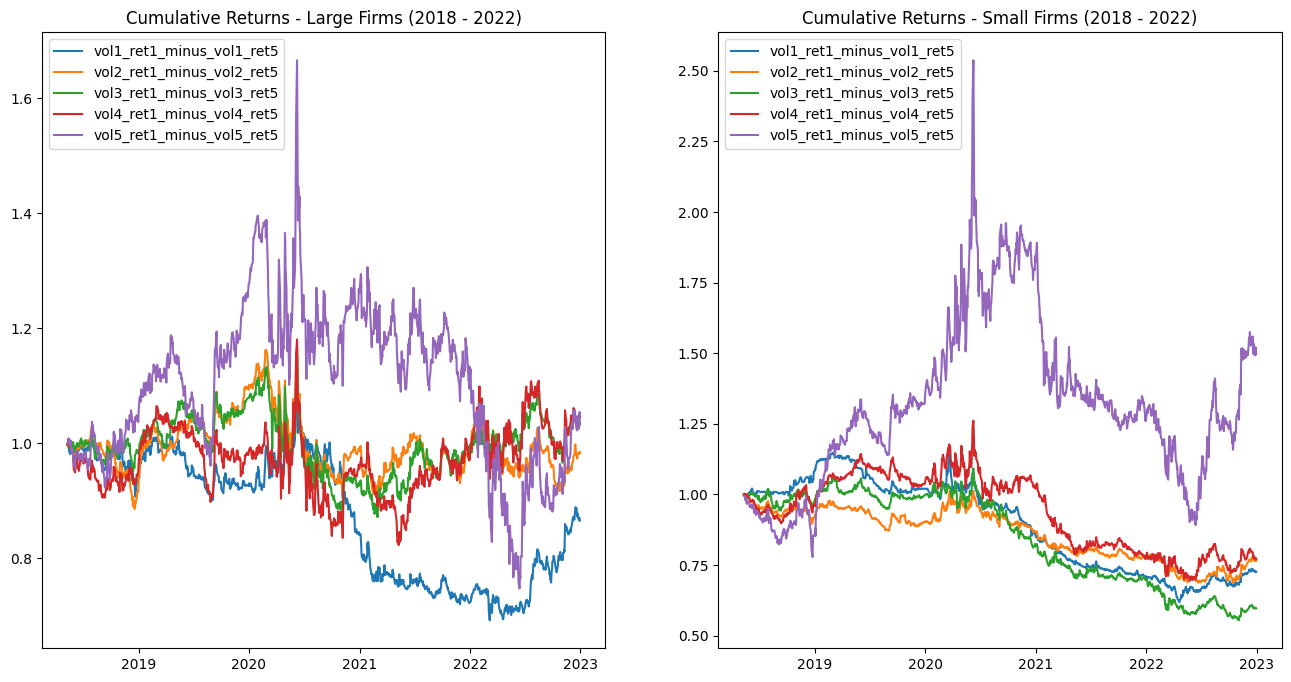

In [77]:
labels = rets2018_largecap_ls_3010.columns
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot((rets2018_largecap_ls_3010+1).cumprod(), label=labels)
ax[0].legend(loc='upper left')
ax[0].set_title("Cumulative Returns - Large Firms (2018 - 2022)")
ax[1].plot((rets2018_smallcap_ls_3010+1).cumprod(), label=labels)
ax[1].legend(loc='upper left')
ax[1].set_title("Cumulative Returns - Small Firms (2018 - 2022)")
#sns.scatterplot(x='feature_20', y = 'feature_15', data=df, hue='Class', ax=ax[1])
plt.show()

#### Summary Statistics Large Firms (2018-2022)

In [78]:
summary_stats(rets2018_largecap_ls_3010, 252, .03) #For the sharpe ratio, I am assuming a risk free rate of 3%

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
vol1_ret1_minus_vol1_ret5,-0.030658,0.126391,0.625014,5.436915,0.011319,0.015940,-0.466008,-0.363689
vol2_ret1_minus_vol2_ret5,-0.003572,0.137778,0.703266,7.404132,0.011661,0.018455,-0.236608,-0.225288
vol3_ret1_minus_vol3_ret5,0.007179,0.161439,0.797455,8.333371,0.013121,0.021232,-0.137267,-0.249169
vol4_ret1_minus_vol4_ret5,0.009797,0.203769,1.083315,10.606913,0.014781,0.026430,-0.096282,-0.303147
vol5_ret1_minus_vol5_ret5,0.010387,0.299125,0.617751,6.036698,0.026167,0.040256,-0.063682,-0.551530


#### Summary Statistics Small Firms (2018-2022)

In [79]:
summary_stats(rets2018_smallcap_ls_3010, 252, .03) #For the sharpe ratio, I am assuming a risk free rate of 3%

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
vol1_ret1_minus_vol1_ret5,-0.066384,0.107409,1.279363,25.083514,0.005693,0.015907,-0.871322,-0.469439
vol2_ret1_minus_vol2_ret5,-0.055874,0.105336,0.710883,7.936134,0.009052,0.014069,-0.791582,-0.323360
vol3_ret1_minus_vol3_ret5,-0.105306,0.129894,0.400269,5.609856,0.012475,0.017897,-1.011444,-0.492020
vol4_ret1_minus_vol4_ret5,-0.054595,0.172011,0.623218,5.879726,0.015353,0.022987,-0.477540,-0.449236
vol5_ret1_minus_vol5_ret5,0.091132,0.337830,0.676905,6.918143,0.028461,0.044360,0.175684,-0.648541


### Formation 60 - trading 10

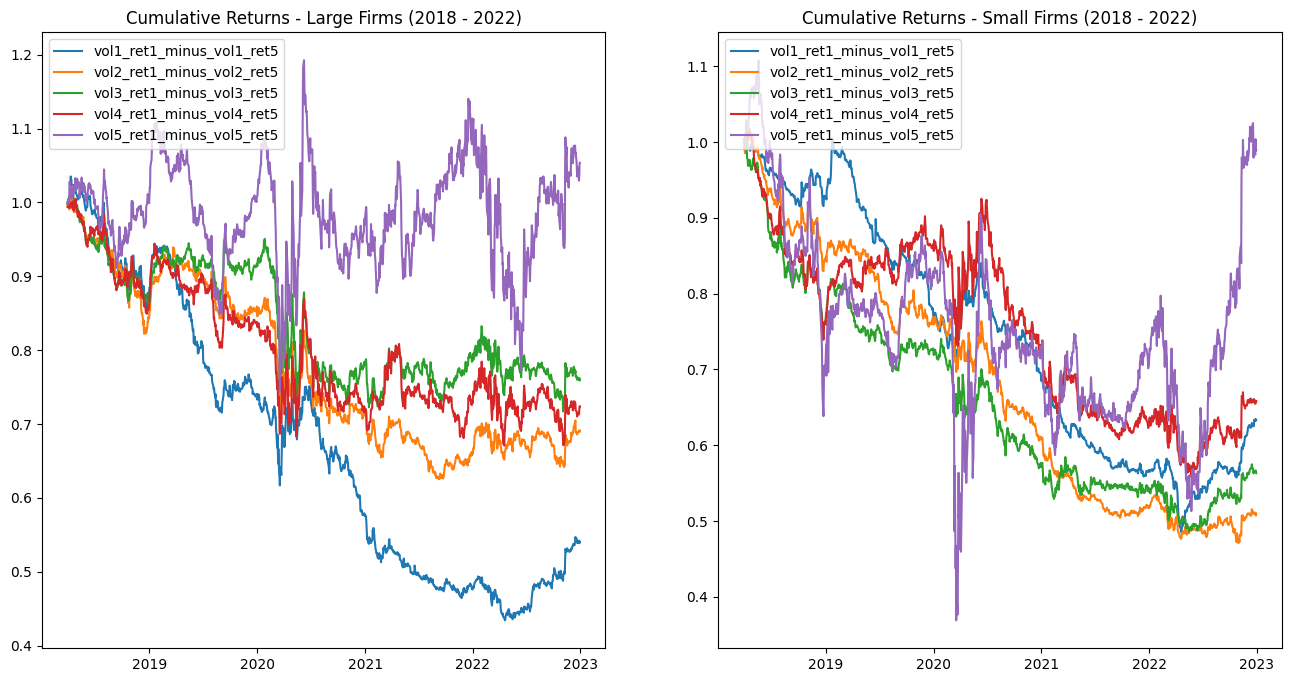

In [59]:
labels = rets2018_largecap_ls_6010.columns
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot((rets2018_largecap_ls_6010+1).cumprod(), label=labels)
ax[0].legend(loc='upper left')
ax[0].set_title("Cumulative Returns - Large Firms (2018 - 2022)")
ax[1].plot((rets2018_smallcap_ls_6010+1).cumprod(), label=labels)
ax[1].legend(loc='upper left')
ax[1].set_title("Cumulative Returns - Small Firms (2018 - 2022)")
#sns.scatterplot(x='feature_20', y = 'feature_15', data=df, hue='Class', ax=ax[1])
plt.show()

#### Summary Statistics Large Firms (2018-2022)

In [60]:
summary_stats(rets2018_largecap_ls_6010, 252, .03) #For the sharpe ratio, I am assuming a risk free rate of 3%

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
vol1_ret1_minus_vol1_ret5,-0.121626,0.133237,0.416012,7.906692,0.012429,0.018450,-1.104995,-0.580496
vol2_ret1_minus_vol2_ret5,-0.075020,0.130039,0.702716,10.819716,0.010741,0.017495,-0.784176,-0.382468
vol3_ret1_minus_vol3_ret5,-0.056207,0.147381,0.653968,9.150882,0.012500,0.019992,-0.567957,-0.295473
vol4_ret1_minus_vol4_ret5,-0.065659,0.181581,1.031947,8.690402,0.014116,0.024163,-0.511531,-0.332606
vol5_ret1_minus_vol5_ret5,0.011044,0.280885,0.678875,6.866782,0.023947,0.038329,-0.065543,-0.352423


#### Summary Statistics Small Firms (2018-2022)

In [61]:
summary_stats(rets2018_smallcap_ls_6010, 252, .03) #For the sharpe ratio, I am assuming a risk free rate of 3%

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
vol1_ret1_minus_vol1_ret5,-0.091659,0.099365,0.727624,16.078265,0.007646,0.014738,-1.188832,-0.516592
vol2_ret1_minus_vol2_ret5,-0.132264,0.101257,0.144070,6.746423,0.010284,0.015162,-1.555984,-0.537127
vol3_ret1_minus_vol3_ret5,-0.113667,0.128968,0.265862,5.951526,0.012695,0.018118,-1.081657,-0.516895
vol4_ret1_minus_vol4_ret5,-0.084067,0.172525,0.639916,7.795310,0.015048,0.023092,-0.641981,-0.450672
vol5_ret1_minus_vol5_ret5,-0.002286,0.424511,-0.088133,22.443463,0.033793,0.060121,-0.073873,-0.666704
